In [1]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pandas as pd
import numpy as np
import string
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
## Initialize needed variables and set up pipelines for tokenizations

train = pd.read_pickle('Preprocessing_Train.pkl')
X_train, X_test, y_train, y_test = train_test_split(train.name, train.label, test_size=0.25)

stop_words = stopwords.words('english')
non_neg_stop = [i for i in stop_words if "n't" not in i and "no" not in i]
lemma = WordNetLemmatizer()


def pos(x):
    if x.startswith('J'):
        return 'a'
    elif x.startswith('V'):
        return 'v'
    elif x.startswith('R'):
        return 'r'
    else:
        return 'n'
    
    
def tok(doc, non_neg=False, lemmatized=False):
    
    if non_neg:
        stop = non_neg_stop
    else:
        stop = stop_words
       
    tokens = re.split(r'\s', doc.lower())
    
    if lemmatized:
        pos_list = nltk.pos_tag(tokens)
        tokens = list(map(lambda x: lemma.lemmatize(x[0], pos(x[1])), pos_list))    

    tokens = [i for i in tokens if i not in stop]
    tokens = [i for i in tokens if len(re.findall(r'\w', i)) >= 2]
    tokens = [re.findall(r"\w[a-zA-Z0-9.-]*\w", i)[0] for i in tokens if re.findall(r"\w[a-zA-Z0-9.-]*\w", i)]
    
    return tokens


def get_voc_new(X, non_neg=True, lemmatized=True):
    
    voc = []
    token_list = []
    for i in X:
        tokens = tok(i, non_neg, lemmatized)
        token_list.append(tokens)
        voc += tokens
        
    voc = list(set(voc))
    
    return voc, token_list

In [3]:
## tokenize train set and test set, create a vocabulary-index dictionary only based on train set

voc, tk_list_train = get_voc_new(X_train, False, True)
voc_test, tk_list_test = get_voc_new(X_test, False, True)
voc_dic = {item: idx+1 for idx, item in enumerate(voc)}

## MLP_TFIDF

In [32]:
tfidf = TfidfVectorizer(vocabulary=voc)
vec_train = tfidf.fit_transform(X_train)
vec_test = tfidf.transform(X_test)

class _dataset(Dataset):
    
    def __init__(self, X, y):
        super(_dataset, self).__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
_train = _dataset(vec_train.toarray(), np.array(list(y_train)))
_test = _dataset(vec_test.toarray(), np.array(list(y_test)))


## 此处网络架构可更改

class MLP_model(nn.Module):
    
    def __init__(self):

        super(MLP_model, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(vec_train.shape[1], 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.Sigmoid())

            
    def forward(self, x):
        return self.net(x)

In [33]:
def train_model(model, train_dataset, eval_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'eval_loss': [], 'detail_train': [], 'detail_eval': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

    model = model.to(device)
    save_loss = nn.BCELoss(reduction='none').to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        eval_loss = 0
        detail_train = torch.zeros(50).to(device)
        detail_eval = torch.zeros(50).to(device)
        pred = []
        real = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            loss = Loss(out, y)
            save_train = save_loss(out, y).sum(0)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            detail_train += save_train
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X)
                loss = Loss(out, y)
                save_eval = save_loss(out, y).sum(0)
                detail_eval += save_eval
                eval_loss += loss
                pred.append(out.cpu())
                real.append(y.cpu())
                
        train_loss = (train_loss/len(train_loader)).item()
        eval_loss = (eval_loss/len(eval_loader)).item() 
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)  
        history['detail_train'].append(detail_train.cpu().detach())
        history['detail_eval'].append(detail_eval.cpu().detach())  
        
        if not (epoch+1)%50:
            res = torch.cat(pred)
            tru = torch.cat(real)
            print(f'\nepoch {epoch+1}:\n')
            print(f"f1_score for 50 classes: {f1_score(tru, np.round(res), average='macro')}")
            print(classification_report(tru.view(-1), np.round(res).view(-1)))
            print(f'\nSpent time: {time.time()-start} seconds')
            
        
    print('Training complete!')
    
    return history

In [34]:
model_A = MLP_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
lr = 3e-4
batch_size = 128
norm = None
hist = train_model(model_A, _train, _test, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

Training start!

epoch 50:

f1_score for 50 classes: 0.554184688687889
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96    111367
         1.0       0.75      0.47      0.58     11883

    accuracy                           0.93    123250
   macro avg       0.85      0.73      0.77    123250
weighted avg       0.93      0.93      0.93    123250


Spent time: 12.90113353729248 seconds
Training complete!


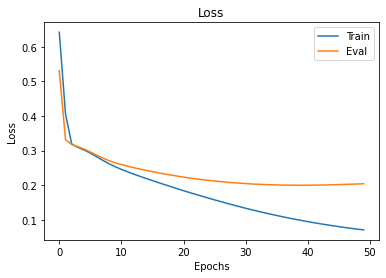

In [35]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

In [36]:
count = torch.unique(torch.cat([i.argsort(descending=True)[:20] for i in hist['detail_train']]).cpu(), return_counts=True)

count_dic = dict(zip(list(map(lambda x: x.item(), count[0])), list(map(lambda x: x.item(), count[1]))))

# dang = [i for i in count_dic if count_dic[i]>50]

label = pd.read_csv('Label_ID.csv').iloc[:, 1:]

label['freq'] = torch.Tensor(np.array(list(train.label))).sum(0)

loss_record = torch.stack([i.cpu().detach() for i in hist['detail_train']]).transpose(-2,-1)

loss_record[:, -200:].mean(-1).sort()

torch.return_types.sort(
values=tensor([ 934.4386,  972.8385,  978.6216,  996.8713, 1019.8055, 1028.3121,
        1035.8997, 1045.6050, 1065.6808, 1066.5660, 1069.3801, 1094.0471,
        1095.0043, 1144.5621, 1149.0015, 1160.5941, 1179.5292, 1179.8958,
        1191.2023, 1209.0796, 1240.5188, 1267.0258, 1269.5858, 1289.0891,
        1326.1542, 1372.7423, 1372.9866, 1385.0543, 1386.9832, 1399.8052,
        1428.8062, 1432.8528, 1435.2834, 1441.3328, 1443.9816, 1496.2521,
        1496.7850, 1515.9653, 1538.0697, 1554.0072, 1554.2924, 1592.9943,
        1609.8549, 1657.5610, 1775.0620, 1787.8292, 1789.3445, 1823.3555,
        1880.5704, 1888.9866]),
indices=tensor([32, 28, 45, 49,  4, 43, 19, 47, 15, 36, 26,  3,  8, 17, 18, 11, 41, 34,
        21,  1, 10, 37, 48, 16, 40, 23, 31, 25, 30, 27, 33, 42,  7,  2, 14,  0,
        24,  6, 44, 35, 38,  9, 22, 39, 20, 13, 46,  5, 29, 12]))

## Attention_embedding

In [9]:
## Convert tokens to index according to the dictionary we create in the last step 
## The unfound tokens would be padded with 0

def word2idx(token_list):
    
    token_idx = []
    for sent in token_list:
        sent_list = []
        for token in sent:
            if token in voc_dic:
                idx = voc_dic[token]
            else:
                idx = 0
            sent_list.append(idx)
        token_idx.append(sent_list)

    return token_idx


tk_idx_train = word2idx(tk_list_train)
tk_idx_test = word2idx(tk_list_test)

In [10]:
## Create a Pytorch Dataset class to convert data to tensors
## Each token index list is set to the same length, 1024 by default
## The shorter one would be padded with 0, and the longer one would be truncated

class dataset_(Dataset):
    
    def __init__(self, X, y, max_len=128):
        super(dataset_, self).__init__()
        pad = [i[:max_len] + [0]*(max_len-len(i[:max_len])) for i in X]
        self.X = torch.tensor(pad, dtype=torch.int32)
        self.y = torch.Tensor(np.array(list(y)))
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
train_ = dataset_(tk_idx_train, y_train)
test_ = dataset_(tk_idx_test, y_test)

In [11]:
# class PE(nn.Module): 

#     def __init__(self, dim_emb=256, dropout=0.5, max_len=1024): 
#         super(PE, self).__init__() 
#         self.dropout = nn.Dropout(dropout) 
#         pe = torch.zeros(max_len, dim_emb) 
#         position = torch.arange(0, max_len).unsqueeze(1) 
#         div_term = torch.exp(-math.log(10000) * torch.arange(0, dim_emb, 2)/dim_emb)
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term) 
#         pe = pe.unsqueeze(0) 
#         self.register_buffer('pe', pe) 
        
#     def forward(self, x): 
#         x = x + Variable(self.pe[:, :], requires_grad=False) 
#         return self.dropout(x) 

    
class Att(nn.Module):
    
    def __init__(self, dim_emb=256):
        super(Att, self).__init__()
        self.Wq = nn.Linear(dim_emb, 50, bias=False)
        self.Wk = nn.Linear(dim_emb, dim_emb, bias=False)
        self.Wv = nn.Linear(dim_emb, dim_emb, bias=False)

    def forward(self, x):
        K = self.Wk(x) 
        V = self.Wv(x)
        temp = self.Wq(K) 
        score = temp.transpose(-2, -1) / math.sqrt(K.size(-1)) ## (50, 1200)
        return torch.matmul(nn.Softmax(dim=-1)(score), V)
    
    
class Emb(nn.Module):
    
    def __init__(self, voc_size=len(voc)+1, dim_emb=256):
        super(Emb, self).__init__()
        self.emb = nn.Embedding(voc_size, dim_emb, padding_idx=0)
        self.trans = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())

    def forward(self, x):
        basic = self.emb(x)
        return (self.trans(basic.transpose(-2, -1))).transpose(-2, -1)     
    
    
class LN(nn.Module):
    
    def __init__(self, dim_emb=256):
        super(LN, self).__init__()
        self.feed = nn.LayerNorm(dim_emb)

    def forward(self, x):
        return x + self.feed(x)


class final_model(nn.Module):
    
    def __init__(self, voc_size=len(voc)+1, dim_emb=256):
        super(final_model, self).__init__()
        self.net = nn.Sequential(
            # Emb(voc_size, dim_emb),
            nn.Embedding(voc_size, dim_emb, padding_idx=0),
            # PE(dim_emb, dropout, max_len),  ## (1024, dim_emb)
            nn.Dropout(0.5),
            # SelfAtt(dim_emb, dim_emb),
            Att(dim_emb),  ## (50, dim_emb)
            nn.Linear(dim_emb, dim_emb),
            nn.ReLU(),
            nn.Linear(dim_emb, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid())
            
    def forward(self, x):
        return self.net(x)

In [12]:
def train_model(model, train_dataset, eval_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'eval_loss': [], 'detail_train': [], 'detail_eval': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

    model = model.to(device)
    save_loss = nn.BCELoss(reduction='none').to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        eval_loss = 0
        detail_train = torch.zeros(50).to(device)
        detail_eval = torch.zeros(50).to(device)
        pred = []
        real = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X).squeeze(-1)
            loss = Loss(out, y)
            save_train = save_loss(out, y).sum(0)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            detail_train += save_train
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X).squeeze(-1)
                loss = Loss(out, y)
                save_eval = save_loss(out, y).sum(0)
                detail_eval += save_eval
                eval_loss += loss
                pred.append(out.cpu())
                real.append(y.cpu())
                
        train_loss = (train_loss/len(train_loader)).item()
        eval_loss = (eval_loss/len(eval_loader)).item() 
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)  
        history['detail_train'].append(detail_train.cpu().detach())
        history['detail_eval'].append(detail_eval.cpu().detach())  
        
        if not (epoch+1)%50:
            res = torch.cat(pred)
            tru = torch.cat(real)
            print(f'\nepoch {epoch+1}:\n')
            print(f"f1_score for 50 classes: {f1_score(tru, np.round(res), average='macro')}")
            print(classification_report(tru.view(-1), np.round(res).view(-1)))
            print(f'\nSpent time: {time.time()-start} seconds')
            
        
    print('Training complete!')
    
    return history

Training start!

epoch 50:

f1_score for 50 classes: 0.29591522149011906
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96    111367
         1.0       0.75      0.22      0.35     11883

    accuracy                           0.92    123250
   macro avg       0.84      0.61      0.65    123250
weighted avg       0.91      0.92      0.90    123250


Spent time: 20.358864068984985 seconds

epoch 100:

f1_score for 50 classes: 0.38201210323709955
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    111367
         1.0       0.74      0.30      0.43     11883

    accuracy                           0.92    123250
   macro avg       0.84      0.64      0.69    123250
weighted avg       0.91      0.92      0.91    123250


Spent time: 39.24065089225769 seconds

epoch 150:

f1_score for 50 classes: 0.4116982173409067
              precision    recall  f1-score   support

         0.0       0.93 

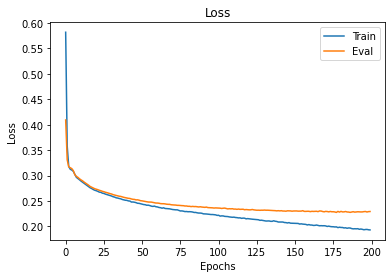

In [13]:
## 3-layer ReLU
mod = final_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4 
batch_size = 128
norm = None
hist = train_model(mod, train_, test_, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

In [14]:
count = torch.unique(torch.cat([i.argsort(descending=True)[:20] for i in hist['detail_train']]).cpu(), return_counts=True)

count_dic = dict(zip(list(map(lambda x: x.item(), count[0])), list(map(lambda x: x.item(), count[1]))))

dang = [i for i in count_dic if count_dic[i]>50]

label = pd.read_csv('Label_ID.csv').iloc[:, 1:]

label['freq'] = torch.Tensor(np.array(list(train.label))).sum(0)

loss_record = torch.stack([i.cpu().detach() for i in hist['detail_train']]).transpose(-2,-1)

loss_record[:, -200:].mean(-1).sort()

torch.return_types.sort(
values=tensor([1107.7393, 1124.9547, 1151.8700, 1185.5464, 1192.2418, 1203.9098,
        1232.9432, 1249.8453, 1254.6663, 1285.3098, 1285.4663, 1293.7168,
        1297.4137, 1375.3612, 1392.7500, 1397.9263, 1436.6772, 1450.5397,
        1458.8475, 1486.0479, 1510.0283, 1511.2981, 1562.1249, 1620.8265,
        1772.1820, 1773.5280, 1773.9418, 1793.8608, 1823.5208, 1836.0001,
        1865.9307, 1875.3999, 1885.1289, 1894.1240, 1944.2117, 1950.5309,
        1975.8391, 1980.1881, 2012.4928, 2063.5020, 2069.7146, 2070.8843,
        2099.1548, 2242.4253, 2255.2537, 2308.0007, 2364.6797, 2475.2498,
        2513.4060, 2525.1426]),
indices=tensor([45, 32, 19, 49, 26, 28, 36,  4, 17,  8, 15,  3, 47, 41, 10, 11, 21, 18,
        37, 40, 43,  1, 48, 34, 42, 16, 25,  7, 30, 27, 31, 23,  2,  9, 35,  0,
         6, 22, 24, 44, 33, 39, 14, 38, 13, 20,  5, 46, 29, 12]))

In [12]:
label = pd.read_csv('new.csv')

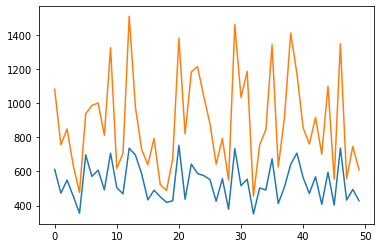

In [20]:
plt.plot(label.tfidf_loss)
plt.plot(label.word_emb_loss);

In [161]:
def top_trash(top):
    return label.iloc[list(map(lambda x: x.item(), loss_record[:, -100:].mean(-1).argsort(descending=True)[:top]))]

lj = top_trash(10)

In [195]:
df = pd.read_csv('new.csv')

In [202]:
df.sort_values('word_emb_loss', ascending=False)

,label_idx,cat_name,freq,word_emb_loss,tfidf_loss
12,12,Examinations,1742,1508.59060,735.76843
29,29,Market Risk,1633,1459.37990,733.05610
38,38,Regulatory Actions,1621,1410.24390,641.18933
20,20,Information Filing,1387,1380.03830,752.63450
46,46,Securities Sales,1737,1347.42590,736.52360
35,35,Powers and Duties,797,1341.56190,673.45667
9,9,Corporate Governance,958,1324.72840,706.44617
23,23,Legal Proceedings,1343,1213.14010,587.49770
31,31,Money Services,869,1185.53810,553.87445
22,22,Legal,907,1182.30140,642.60410


In [171]:
top_trash(50)

,label_idx,cat_name,freq
12,12,Examinations,1742.0
29,29,Market Risk,1633.0
20,20,Information Filing,1387.0
38,38,Regulatory Actions,1621.0
9,9,Corporate Governance,958.0
35,35,Powers and Duties,797.0
46,46,Securities Sales,1737.0
22,22,Legal,907.0
23,23,Legal Proceedings,1343.0
31,31,Money Services,869.0


ValueError: columns overlap but no suffix specified: Index(['label_idx', 'cat_name', 'freq', 'word_emb_loss'], dtype='object')

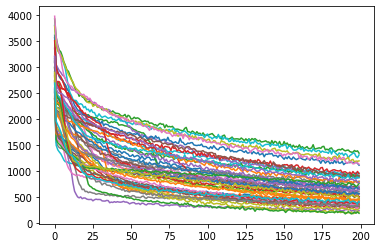

In [60]:
for i in torch.stack([i.cpu().detach() for i in hist['detail_train']]).transpose(-2,-1):
    plt.plot(i)

In [15]:
with torch.no_grad():
    res = mod.cpu()(test_.X).squeeze(-1)

print(classification_report(test_.y, np.round(res)))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       218
           1       0.81      0.68      0.74       226
           2       0.80      0.82      0.81       259
           3       0.74      0.78      0.76       158
           4       0.84      0.82      0.83       178
           5       0.80      0.95      0.87       350
           6       0.86      0.77      0.81       244
           7       0.75      0.79      0.77       286
           8       0.53      0.50      0.51       132
           9       0.62      0.65      0.64       248
          10       0.67      0.95      0.78       153
          11       0.76      0.81      0.79       216
          12       0.73      0.69      0.71       439
          13       0.85      0.75      0.80       313
          14       0.89      0.88      0.89       294
          15       0.72      0.68      0.70       119
          16       0.87      0.75      0.81       300
          17       0.62    

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
f1_score(test_.y, np.round(res), average='macro')

0.7379395941552097

In [16]:
with torch.no_grad():
    res0 = mod.cpu()(train_.X).squeeze(-1)


print(classification_report(train_.y, np.round(res0)))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       717
           1       0.98      0.92      0.95       654
           2       0.95      0.95      0.95       819
           3       0.95      0.96      0.95       512
           4       0.90      0.97      0.94       504
           5       0.84      0.98      0.91      1041
           6       0.96      0.94      0.95       725
           7       0.91      0.94      0.92       867
           8       0.90      0.87      0.88       386
           9       0.89      0.90      0.89       710
          10       0.75      1.00      0.86       417
          11       0.86      0.97      0.91       605
          12       0.94      0.93      0.94      1303
          13       0.97      0.95      0.96       877
          14       0.96      0.97      0.96      1007
          15       0.93      0.97      0.95       416
          16       0.98      0.96      0.97       878
          17       0.66    

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
